#### **Semantic Segmentation using UNet on Cityscapes Data**

**Image Segmentation**: In the image segmentation task, the machine partitions the image into different segments, each of them representing a different entity.Hence, segmentating image in different parts which shows a semantic parition of the image.

Image segmentation is useful in many fields from *self-driving cars, satellites, medical imaging*. The subtleties in medical images are quite complex and sometimes even challenging for trained physicians. A machine that can understand these nuances and can identify necessary areas can make a profound impact in medical care.

<br>

**CNN/UNet for Image Segmentation**: Convolutional Neural Networks gives decent results in easier image segmentation problems but it hasn't made any good progress on complex ones. That’s where *UNet* comes in the picture. UNet was first designed especially for medical image segmentation. It showed such good results that it used in many other fields after.


**CNN**: The main idea behind CNN is to learn the feature mapping of an image. This works well in classification problems as the image is converted into a vector which used further for classification. But in image segmentation, we not only need to convert feature map into a vector but also reconstruct an image from this vector. This is a mammoth task because it’s a lot tougher to convert a vector into an image than vice versa.

**Idea of UNet**: While converting an image into a vector, we already learned the feature mapping of the image so why not use the same mapping to convert it again to image. This is the recipe behind UNet. Use the same feature maps that are used for contraction to expand a vector to a segmented image. This would preserve the structural integrity of the image which would reduce distortion enormously.


#### **Load Processed Archive**

In [1]:
from google.colab import drive
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/Fall2020/ADL_Final/'


Mounted at /gdrive


In [2]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
# UNet specific imports
import cv2
from sklearn.cluster import KMeans
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
COLAB_DIR = '/content/'

In [3]:
def download_if_missing(url, target, extract=True):
    if os.path.exists(target):
        return target
    return tf.keras.utils.get_file(target, origin=url, extract=extract)

gt_url_file = 'https://storage.googleapis.com/mcg2208/gtFine.zip'
im_url_file = 'https://storage.googleapis.com/mcg2208/leftImg.zip'

gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')

download_if_missing(gt_url_file, gt_file, extract=False)
download_if_missing(im_url_file, im_file, extract=False)

!unzip -q $gt_file -d $gt_dir
!unzip -q $im_file -d $im_dir


338722816/338717519 [==============================] - 19s 0us/step


In [4]:
# normalize image pixels
IMG_SIZE1 =200
IMG_SIZE2 =256
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE1, IMG_SIZE2])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds1 = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_train_ds1 = gt_train_ds1.map(load_and_preprocess_image)

gt_test_ds1 = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))
gt_test_ds1 = gt_test_ds1.map(load_and_preprocess_image)

gt_val_ds1 = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_val_ds1 = gt_val_ds1.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_train_ds = im_train_ds.map(load_and_preprocess_image)

im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))
im_test_ds = im_test_ds.map(load_and_preprocess_image)

im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_val_ds = im_val_ds.map(load_and_preprocess_image)

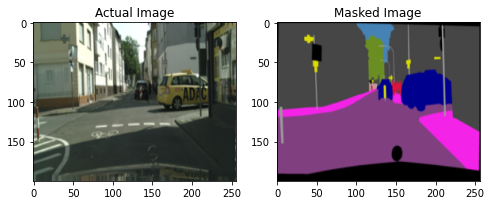

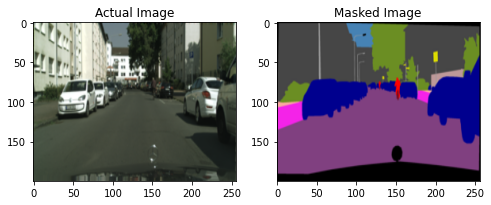

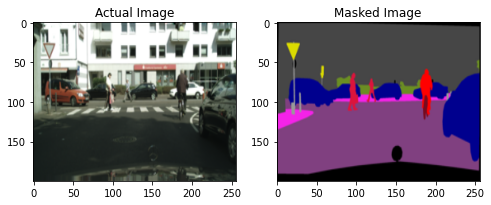

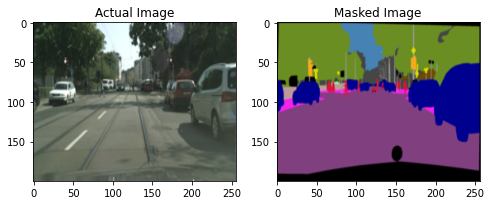

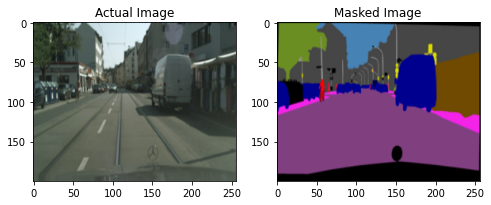

In [5]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

for img, gt in list(zip(im_val_ds.take(5), gt_val_ds1.take(5))):
    visualize_images(img, gt, None)

#### **Specific data transformation using K-means clustering for UNet**

In [6]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg
    
def train_kmeans(K=13):
  colors = []
  kmeans_gt_train_paths = [GT_DIR + 'train/' + path for path in listdir(GT_DIR + 'train/')[:20]]
  kmeans_gt_train_ds = tf.data.Dataset.from_tensor_slices(kmeans_gt_train_paths)
  kmeans_gt_train_ds = kmeans_gt_train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

  for seg in kmeans_gt_train_ds:
    colors.append(tf.reshape(seg, (seg.shape[0]*seg.shape[1], 3) ))
  colors = tf.concat(colors, 0) 
  print("Training K means on colors data of shape :",colors.shape)
  print('data for clustering', type(colors))
  km = KMeans(K)
  km.fit(colors)
  print("K-means clustering trained\n", km)
  return km

# Traing a k-means classifier
km=train_kmeans(13)

def load_and_preprocess_segment(path):
    seg = load_and_preprocess_image(path)
    s = tf.reshape(seg, (seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = tf.reshape(s, (seg.shape[0], seg.shape[1]))
    n = len(km.cluster_centers_)
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        cls[:,:,i]=m

    seg = tf.convert_to_tensor(cls, dtype=tf.float32)
    return seg
    # return ColorsToClass(seg)


Training K means on colors data of shape : (1024000, 3)
data for clustering <class 'tensorflow.python.framework.ops.EagerTensor'>
K-means clustering trained
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [ ]:
# train data
gt_train_paths = get_image_paths(GT_DIR+'train/')
gt_train_ds = map(load_and_preprocess_segment, gt_train_paths)
gt_train_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_train_ds])
train_ds = tf.data.Dataset.zip((im_train_ds, gt_train_ds))
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

len(train_ds), next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape

In [ ]:
# val data
gt_val_paths = get_image_paths(GT_DIR+'val/')
gt_val_ds = map(load_and_preprocess_segment, gt_val_paths)
gt_val_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_val_ds])
val_ds = tf.data.Dataset.zip((im_val_ds, gt_val_ds))
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

len(val_ds), next(iter(val_ds))[0].shape, next(iter(val_ds))[1].shape

In [ ]:
# test data
gt_test_paths = get_image_paths(GT_DIR+'test/')
gt_test_ds = map(load_and_preprocess_segment, gt_test_paths)
gt_test_ds = tf.data.Dataset.from_tensor_slices([a for a in gt_test_ds])
test_ds = tf.data.Dataset.zip((im_test_ds, gt_test_ds))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

len(test_ds), next(iter(test_ds))[0].shape, next(iter(test_ds))[1].shape

(48, TensorShape([32, 200, 256, 3]), TensorShape([32, 200, 256, 13]))

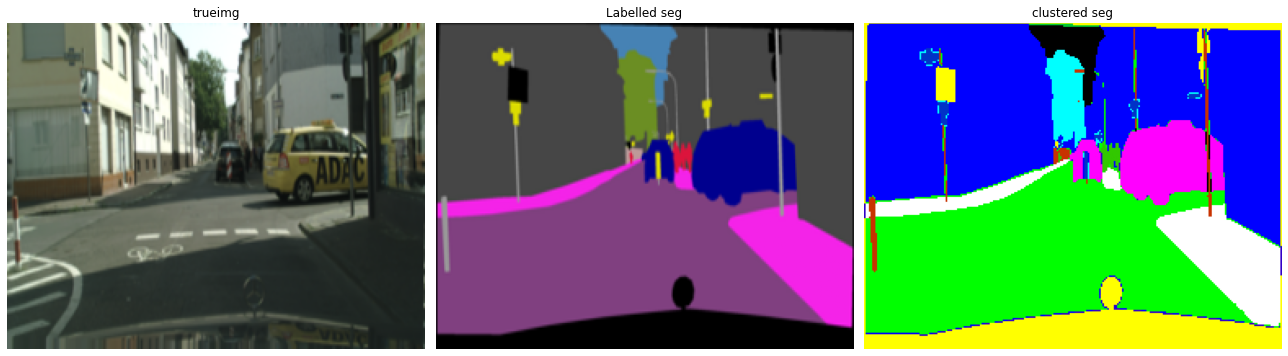

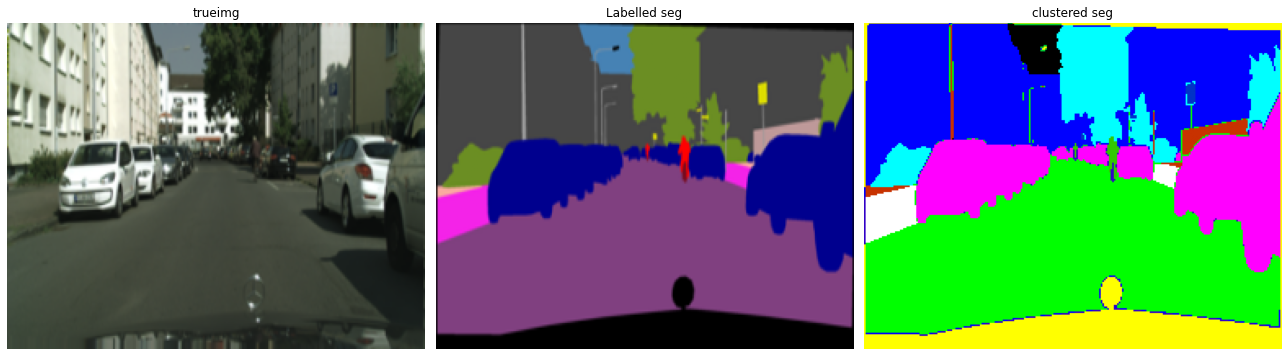

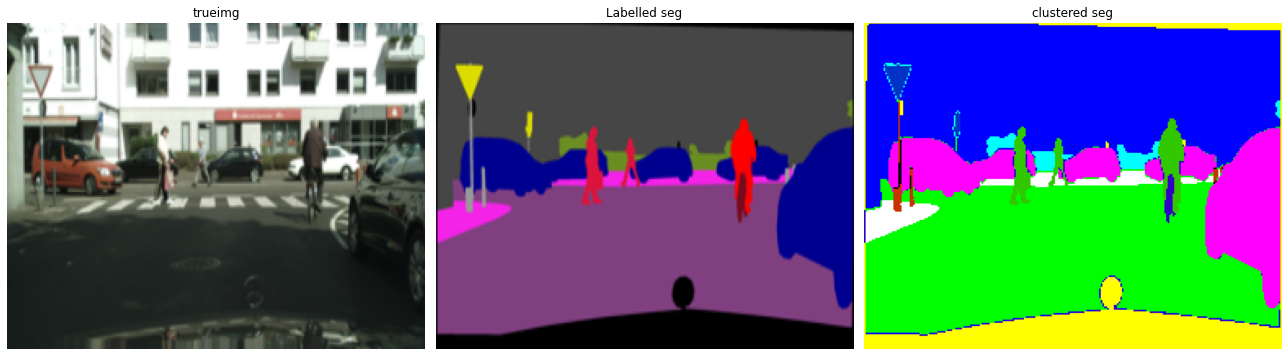

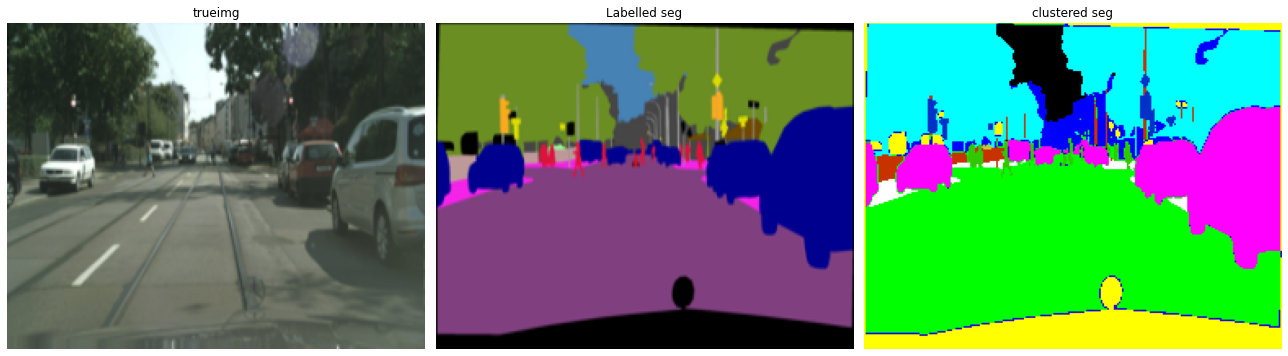

In [ ]:
for b,s in val_ds.take(1):
  for i,segimg in zip(range(4), gt_val_ds1.take(4)):
    trueimg = b[i]
    predimg = LayersToRGBImage(s[i])


    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("trueimg")
    plt.imshow(trueimg)
    plt.axis("off")

    plt.subplot(132)
    plt.title("Labelled seg")
    plt.imshow(segimg)
    plt.axis("off")

    plt.subplot(133)
    plt.title("clustered seg")
    plt.imshow(predimg)
    plt.axis("off")

    plt.tight_layout()
    # plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()


#### **UNet Model**

In [ ]:
def create_model():
  inp = Input(shape=(200, 256, 3))

  x1 = BatchNormalization()(inp)
  x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
  x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
  p1 = MaxPooling2D()(x1)
  #p1 = Dropout(0.2)(p1)

  #x2 = BatchNormalization()(x1)
  x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
  x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
  p2 = MaxPooling2D()(x2)
  #p2 = Dropout(0.2)(p2)

  #x3 = BatchNormalization()(x2)
  x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
  x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
  p3 = MaxPooling2D()(x3)
  #p3 = Dropout(0.2)(p3)

  #x4 = BatchNormalization()(x3)
  x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
  x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
  #x4 = MaxPooling2D()(x4)
  #x4 = Dropout(0.2)(x4)

  x5 = UpSampling2D()(x4)
  x5 = concatenate([x3, x5])
  x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
  x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
  #x5 = Dropout(0.2)(x5)

  x6 = UpSampling2D()(x5)
  x6 = concatenate([x2, x6])
  x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
  x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
  #x6 = Dropout(0.2)(x6)

  x7 = UpSampling2D()(x6)
  x7 = concatenate([x1, x7])
  x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
  x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)


  model = Model(inp, x7)

  opt = Adam(lr=0.0001)
  model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
  return model
# model.summary()

In [ ]:
# checkpoint_dir = os.path.join(drive_root, "Final_Checkpoints")
# # checkpoint_path = os.path.join(checkpoint_dir, "cp.ckpt")
# checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

# # Loading checkpoint
# print("Checkpoints directory is", checkpoint_dir)
# if os.path.exists(checkpoint_dir):
#   print("Checkpoints folder already exists")
# else:
#   print("Creating a checkpoints directory")
#   os.makedirs(checkpoint_dir)

#### **UNet Training**

In [ ]:
#------------------------Loading trained model---------------------------------------
checkpoint_path_old = drive_root+'cpt_12dec/cp.ckpt'
checkpoint_dir_old = os.path.dirname(checkpoint_path_old)
# load model
model = create_model()
model.load_weights(checkpoint_path_old)
# Re-evaluate loaded model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
#---------------------------retrain ------------------------------------
checkpoint_path = drive_root+'cpt_13dec/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Train the model with the new callback
model.fit(train_ds,  
          epochs=3,
          validation_data=val_ds,
          verbose=1,
          callbacks=[cp_callback]) 
# steps_per_epoch=10,
# validation_steps=10,


model.save(drive_root+'trained_model_13dec.h5')

16/16 - 126s - loss: 3.2211 - accuracy: 0.0802
Restored model, accuracy:  8.02%
Epoch 1/3
93/93 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.4917  
Epoch 00001: saving model to /gdrive/My Drive/Fall2020/ADL_Final/cpt_13dec/cp.ckpt
93/93 [==============================] - 6282s 68s/step - loss: 1.4018 - accuracy: 0.4917 - val_loss: 1.2426 - val_accuracy: 0.5501
Epoch 2/3
93/93 [==============================] - ETA: 0s - loss: 0.9279 - accuracy: 0.6299  
Epoch 00002: saving model to /gdrive/My Drive/Fall2020/ADL_Final/cpt_13dec/cp.ckpt
93/93 [==============================] - 6259s 67s/step - loss: 0.9279 - accuracy: 0.6299 - val_loss: 0.9250 - val_accuracy: 0.6280
Epoch 3/3
93/93 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.6570  
Epoch 00003: saving model to /gdrive/My Drive/Fall2020/ADL_Final/cpt_13dec/cp.ckpt
93/93 [==============================] - 6261s 67s/step - loss: 0.8441 - accuracy: 0.6570 - val_loss: 0.8516 - val_accurac

#### **Evaluating on test images**

(200, 256, 3) (200, 256, 3) (200, 256, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.float64'>


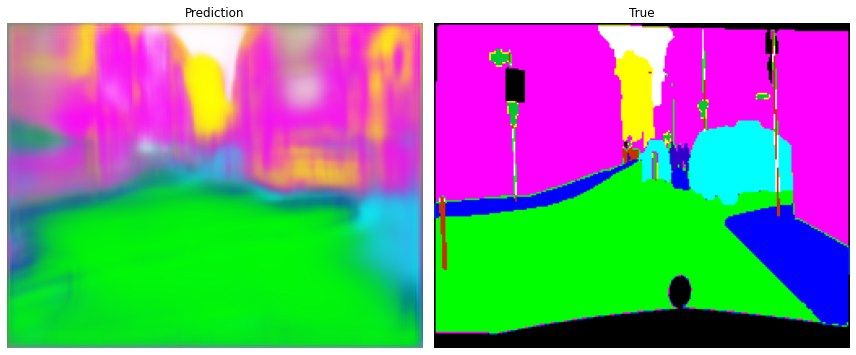

(200, 256, 3) (200, 256, 3) (200, 256, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.float64'>


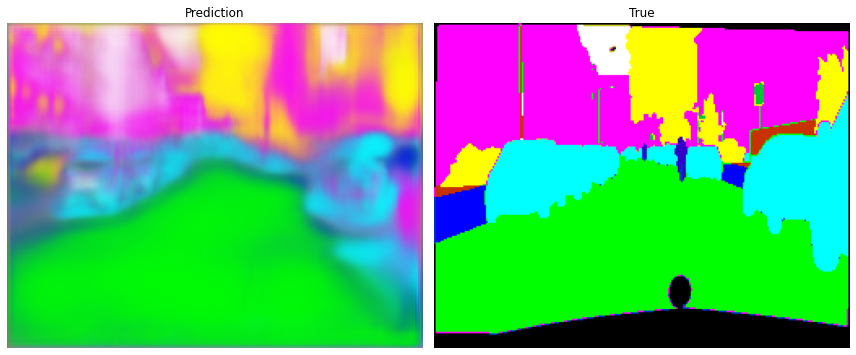

(200, 256, 3) (200, 256, 3) (200, 256, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.float64'>


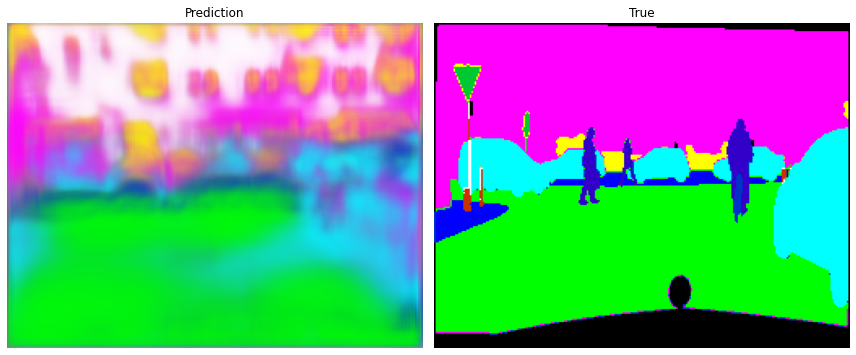

(200, 256, 3) (200, 256, 3) (200, 256, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.float64'>


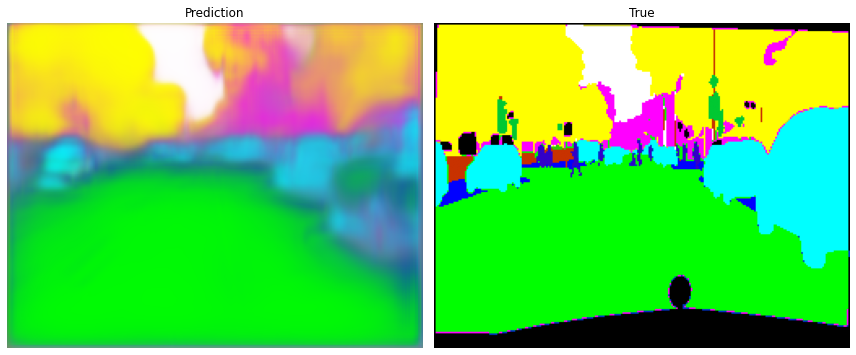

(200, 256, 3) (200, 256, 3) (200, 256, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.float64'>


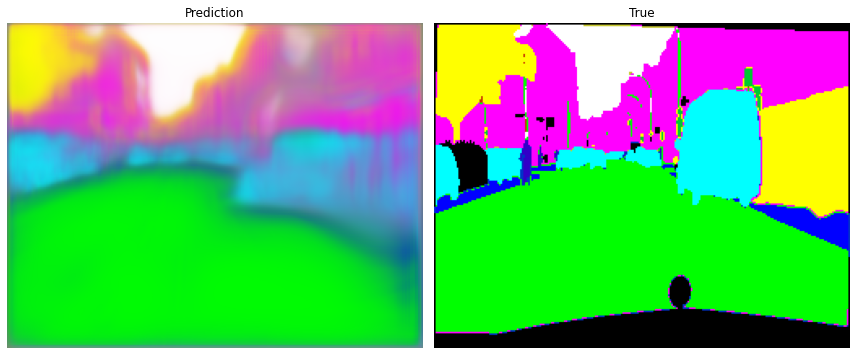

In [ ]:
max_show=4
for imgs, segs in val_ds:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        print(imgs[i].shape, _p.shape, _s.shape, type(imgs[i][0][0][0]), 
              type(_p[0][0][0]))
        predimg = _p
        trueimg = _s
        #predimg = cv2.addWeighted(np.array(imgs[i]), 0.6, np.array(_p), 0.4, 0)
        #trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title("Prediction")
        plt.imshow(predimg)
        plt.axis("off")
        plt.subplot(122)
        plt.title("True")
        plt.imshow(trueimg)
        plt.axis("off")
        plt.tight_layout()
        # plt.savefig("pred_"+str(i)+".png", dpi=150)
        plt.show()
    break

In [ ]:
for x,l in val_ds:
  print(x[0].shape, l[0].shape)
  plt.imshow(LayersToRGBImage(l[0]))
  break

In [ ]:
# Create a basic model instance
model = create_model()

# # Evaluate the model
# loss, acc = model.evaluate(val_ds, verbose=2)
# print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))